In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from pulp import *
from copy import deepcopy
while "notebooks" in os.getcwd():
    os.chdir("..")

from src.preprocessing.parser import Parser
from src.preprocessing.preprocessor import Preprocessor
from src.solvers.solution import Solution
from src.solvers.pulp_solver import PuLPSolver
from src.online.online_allocation import OnlineAllocation

from tqdm import tqdm
from typing import Dict

/tmp/ipykernel_148617/1682056756.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def generate(
    k : int,
    M : int,
    N : int,
    p_max : float,
    r_max : float,
):  
    data : Dict[int, pd.DataFrame] = {}
    for n in range(N):
        index = 0
        data[n] = pd.DataFrame([])
        for m in range(M):
            p_kmn = np.random.randint(1, p_max+1)
            r_kmn = np.random.randint(1, r_max+1)

            pair = {
                "k": [k],
                "m": [m],
                "n": [n],
                "p_k,m,n": [p_kmn],
                "r_k,m,n": [r_kmn]
            }
            
            index += 1
            data[n] = pd.concat([data[n], pd.DataFrame(pair, index= [index])])


    return data


In [4]:
d = generate(5,3,7,100,100)
d[0]

,k,m,n,"p_k,m,n","r_k,m,n"
1,5,0,0,13,22
2,5,1,0,37,9
3,5,2,0,6,79


In [5]:
# K = 10
# M = 2
# N = 4
# p_max = 50
# r_max = 100
# p = 100

# allocated_channels = set()
# data_rate = 0
# total_power = 0

# data : Dict[int , pd.DataFrame] = {n : pd.DataFrame([]) for n in range(N)}


# for k in range(K):
#     data_k = generate(k, M, N, p_max, r_max)

#     for n in range(N):
#         data[n] = pd.concat([data[n], data_k[n]]) 

#     pairs = []
#     for n in range(N):
#         if n in allocated_channels:
#             continue

#         pairs.append(data_k[n])

#     if len(pairs) == 0:
#         break

#     pairs = pd.concat(pairs)
#     pairs['e_k,m,n'] = pairs['r_k,m,n']/pairs['p_k,m,n']
#     sorted_pairs = pairs.sort_values(by='e_k,m,n', ascending=False)

#     power_used = 0

#     for idx, row in sorted_pairs.iterrows():
#         n = row['n']
#         p_kmn = row['p_k,m,n']
#         r_kmn = row['r_k,m,n']

#         if p_kmn + power_used <= p/K:
#             allocated_channels.add(n)
#             power_used += p_kmn
#             total_power += p_kmn
#             data_rate += r_kmn

#             if power_used == p/K:
#                 break

# data_rate, total_power

In [6]:
# compute e_average

def get_e_average(p_max, r_max) -> int:
    e = 0 
    for p_i in range(1,p_max +1):
        for r_i in range(1, r_max + 1):
            
            e+= r_i/p_i

    return e/(p_max*r_max)

In [7]:
def online_solution(
    K : int,
    M : int,
    N : int,
    p_max : int,
    r_max : int,
    p : float,
    tolerance : float = 0.6
):

    allocated_channels = set()
    data_rate = 0
    total_power = 0

    data : Dict[int , pd.DataFrame] = {n : pd.DataFrame([]) for n in range(N)}
    e_avg = get_e_average(p_max, r_max)

    for k in range(K):
        data_k = generate(k, M, N, p_max, r_max)

        for n in range(N):
            data[n] = pd.concat([data[n], data_k[n]]) 

            if n in allocated_channels:
                continue
            
            best_p, best_r = None, None
            for idx, row in data_k[n].iterrows():
                p_i = row['p_k,m,n']
                r_i = row['r_k,m,n']

                if p_i + total_power > p:
                    continue

                if best_p is None:
                    best_p = p_i
                    best_r = r_i

                    continue
                
                if compare(best_p, best_r, p_i, r_i, e_avg):
                    best_p = p_i
                    best_r = r_i

            if best_p is None:
                continue
            
            # We don't have choice if we are on the last user
            if k == K-1:

                allocated_channels.add(n)
                data_rate += best_r
                total_power += best_p

            else:

                if good_enough(best_p, best_r, p_max, r_max, e_avg, tolerance):
                    allocated_channels.add(n)
                    data_rate += best_r
                    total_power += best_p


    return data_rate, total_power, data, allocated_channels

def compare(
    p1 : int, 
    r1 : int, 
    p2 : int, 
    r2 : int, 
    e_average : float
):
    """Returns true if (p2, r2) is better than (p1, r1)

    Args:
        p1 (int): _description_
        r1 (int): _description_
        p2 (int): _description_
        r2 (int): _description_
    
    Returns:
        bool: If (p2, r2) is better than (p1,r1)
    """    
    return r2/p2 > r1/p1
    
    # return r2 - e_average*p2 >= r1 - e_average*p1

def good_enough(p: int, r: int, expected_e: float):
    """Returns true if p/r >= the expected value of p/r

    Args:
        p (int): _description_
        r (int): _description_
        expected_e (float): _description_

    Returns:
        bool: _description_
    """    
    return r/p >= expected_e
    


In [25]:
K = 10
M = 2
N = 4
p_max = 50
r_max = 100
p = 100

n_experiments = 100

used_powers = []
optimal_power = []
optimal_solution = []
sub_optimal_online_solution = []
for attempt in tqdm(range(n_experiments)):
    online_allocator = OnlineAllocation(
        K,
        M,
        N,
        p,
        p_max,
        r_max,
    )
    data_rate, total_power, data = online_allocator.generate_and_solve()

    sub_optimal_online_solution.append(data_rate)
    optimal_power.append(100 + lp_solver.solution.constraints['power_constraint'].value())
    used_powers.append(total_power)

    lp_solver = PuLPSolver(
        K,
        M,
        N,
        p,
        data,
        ilp = True
    )

    lp_solver.solve()

    optimal_solution.append(lp_solver.get_data_rate())

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


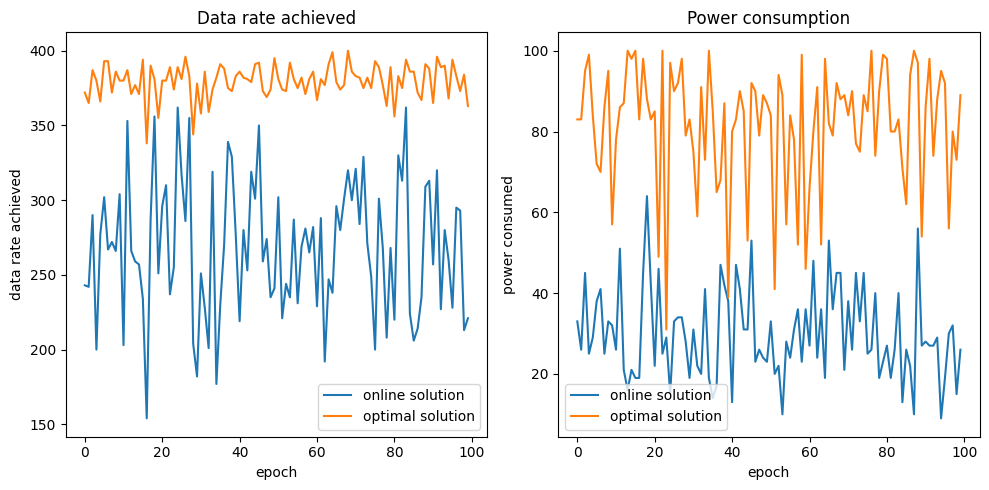

In [43]:
fig, axs = plt.subplots(1, 2, figsize = [10,5])

# Plotting on each subplot

# DATA RATE
axs[0].plot(
    sub_optimal_online_solution,
    label = "online solution"
)
axs[0].plot(
    optimal_solution,
    label = "optimal solution"
)

axs[0].set_title("Data rate achieved")

axs[0].legend()

axs[0].set_xlabel("epoch")
axs[0].set_ylabel("data rate achieved")


#  POWER CONSUMPTION
axs[1].plot(
    used_powers,
    label = "online solution"
)
axs[1].plot(
    optimal_power,
    label = "optimal solution"
)

axs[1].set_title("Power consumption")

axs[1].legend()

axs[1].set_xlabel("epoch")
axs[1].set_ylabel("power consumed")



# Adjusting layout
plt.tight_layout()

# Displaying the plot


plt.savefig("img/multiple_plots_online.png")

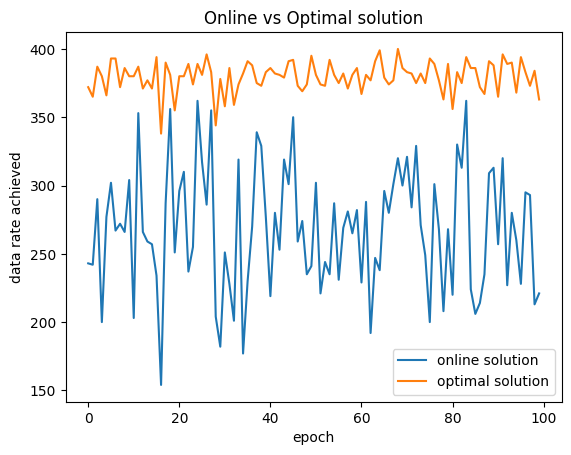

In [31]:
plt.plot(
    sub_optimal_online_solution,
    label = "online solution"
)
plt.plot(
    optimal_solution,
    label = "optimal solution"
)

plt.title("Online vs Optimal solution")

plt.legend()
plt.xlabel("epoch")
plt.ylabel("data rate achieved")

plt.savefig("img/optimal_online.png")

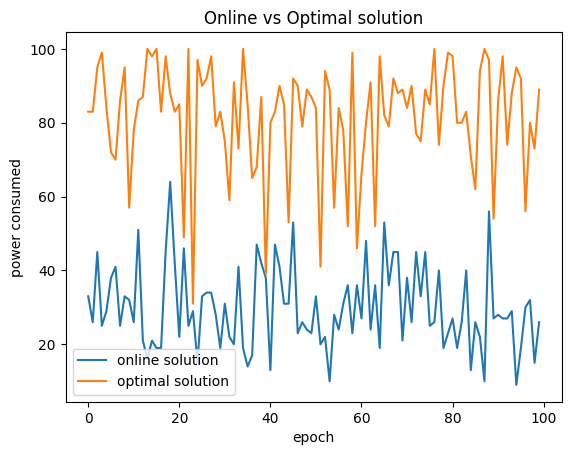

In [30]:
plt.plot(
    used_powers,
    label = "online solution"
)
plt.plot(
    optimal_power,
    label = "optimal solution"
)

plt.title("Online vs Optimal solution")

plt.legend()
plt.xlabel("epoch")
plt.ylabel("power consumed")

plt.savefig("img/power_optimal_online.png")

In [32]:
powers_ratio = [used_powers[i]/ optimal_power[i] for i in range(len(used_powers))]
data_ratio = [sub_optimal_online_solution[i]/optimal_solution[i] for i in range(len(sub_optimal_online_solution))]

In [33]:
np.mean(data_ratio), np.std(data_ratio)

(0.7044677722737347, 0.11293770755991898)

In [36]:
np.mean(used_powers), np.mean(optimal_power)

(29.84, 81.53)

In [34]:
np.mean(powers_ratio), np.std(powers_ratio)

(0.38893225344420673, 0.183335891149441)

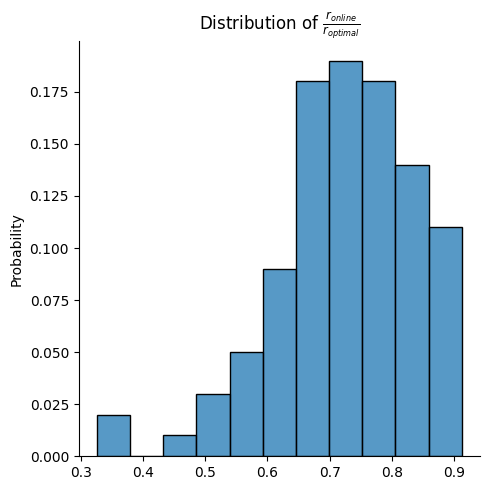

In [16]:
sns.displot(
    data_ratio,
    # kind = 
    stat = "probability"
)

plt.title(r"Distribution of $\frac{r_{online}}{r_{optimal}}$")
plt.savefig("img/optimal_online_distribution.png")
plt.tight_layout()